# Garbage Collecting robot

In [133]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import random

## &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
#### High >> Search >> High(70%) & Low(30%) >> Reward 1.0
#### High >> Wait >> High(100%) >> Reward 0.0
#### High >> Recharge >> High(100%) >> Reward 0.0
#### Low >> Search >> High(80% with battery depletion & Reward -3.0) & Low(20% & Reward 1.0)
#### Low >> Wait >> Low(100%) >> Reward 0.0
#### Low >> Recharge >> High(100%) >> Reward 0.0
## &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

#### Battery recharge at low state has zero reward so its difficult to co-relate it with higher future reward with state being high and searching garbage

In [145]:
class Environment(object):
    import random as random
    import numpy as np
    def __init__(self):
        self.states = ['high','low']
        self.r_srch = 1.0
        self.r_wait = 0.0
        self.r_rechrg = -3
        self.actions = ['search','wait','recharge']
        self.alpha = 0.7
        self.beta = 0.8
        self.current_state = 'high'
    def act(self,action,random=random):
        if action == self.actions[0]:
            if self.current_state == self.states[0]:
                self.current_state = np.random.choice(self.states,p=[self.alpha,1-self.alpha])
                return self.current_state,self.r_srch

            elif self.current_state == self.states[1]:
                self.current_state = np.random.choice(self.states,p=[self.beta,1-self.beta])
                if self.current_state == self.states[0]:
                    return self.current_state,self.r_rechrg
                elif self.current_state == self.states[1]:
                    return self.current_state,self.r_srch
                
        elif action == self.actions[1]:
            if self.current_state == self.states[0]:
                return self.current_state,self.r_wait
            elif self.current_state == self.states[1]:
                return self.current_state,self.r_wait
            
        
        elif action == self.actions[2]:
            if self.current_state == self.states[0]:
                return self.current_state,0
            elif self.current_state == self.states[1]:
                self.current_state = self.states[0]
                return self.current_state,0

In [146]:
env = Environment()

## Robot behaviour with no optimal policy

In [147]:
curr_state = []
actions = []
next_states = []
rewards = []
avg_reward = []
for i in range(20):
    state = env.current_state
    curr_state.append(state)
    action = random.choice(env.actions)
    actions.append(action)
    nxt_state,reward = env.act(action)
    next_states.append(nxt_state)
    rewards.append(reward)
    avg_reward.append(np.mean(rewards))
data = list(zip(curr_state,actions,next_states,rewards))

In [148]:
data

[('high', 'search', 'low', 1.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'search', 'high', -3),
 ('high', 'search', 'low', 1.0),
 ('low', 'search', 'high', -3),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'recharge', 'high', 0),
 ('high', 'search', 'low', 1.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'low', 1.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'search', 'high', -3),
 ('high', 'search', 'low', 1.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'wait', 'low', 0.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'high', 1.0)]

# Formula for Q learning

### Q(S,A)= Q(S,A)+α∗(γ∗maxaQ(S′,a)− Q(S,A))

In [149]:
import pandas as pd

from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time

In [150]:
q_table = {}
for i in env.states:
    for j in env.actions:
        q_table[(i,j)] = 0
qt = pd.DataFrame(columns=['high','low'],index=['search','wait','recharge']).fillna(0)

In [151]:
qt

,high,low
search,0,0
wait,0,0
recharge,0,0


In [152]:
qt
time.sleep(3)
clear_output(wait=True)
avg_ep_reward = []
epsilon = 1
for l in range(10):
    curr_state = []
    actions = []
    next_states = []
    rewards = []
    avg_reward = []
    episode_len = 20
#     epsilon = 0.01
    if l%1 ==0:
        epsilon -= 0.1
    alpha = 0.1
    states_visit = {'high':0,'low':0}
    for i in range(episode_len):
        state = env.current_state
        curr_state.append(state)
        if epsilon > random.random():
            action = random.choice(env.actions)
        else:
#             action = 
            action = [i[1] for i,j in q_table.items() if (i[0] == state)&(j == max([j for i,j in q_table.items() if i[0] == state]))][0]

        actions.append(action)
        nxt_state,reward = env.act(action)
        next_states.append(nxt_state)
        rewards.append(reward)
        avg_reward.append(np.mean(rewards))
        q_table[(state,action)] += reward
        states_visit[state] += 1
        data = list(zip(curr_state,actions,next_states,rewards))
        
        
    total_episode_reward = sum(rewards)
    for l,m,n,o in data:
        q_table[(l,m)] = q_table[(l,m)] + alpha * (max([j for i,j in q_table.items() if i[0] == n]) - q_table[(l,m)])
#         + alpha**2 * (max([j for i,j in q_table.items() if i[0] == state]) - q_table[(state,action)])
        #         q_table[(state,action)] = reward + alpha * (max([j for i,j in q_table.items() if i[0] == nxt_state]) - q_table[(state,action)])
    avg_ep_reward.append(np.sum(rewards))
    qt.loc['search']['high'] = q_table[('high', 'search')]
    qt.loc['search']['low'] = q_table[('low', 'search')]
    qt.loc['wait']['high'] = q_table[('high', 'wait')]
    qt.loc['wait']['low'] = q_table[('low', 'wait')]
    qt.loc['recharge']['high'] = q_table[('high', 'recharge')]
    qt.loc['recharge']['low'] = q_table[('low', 'recharge')]
    qt
    time.sleep(2)
    clear_output(wait=True)
#     print(q_table)

,high,low
search,64,0
wait,30,2
recharge,32,48


### Optimal policy found by robot

In [153]:
curr_state = []
actions = []
next_states = []
rewards = []
avg_reward = []
env = Environment()
for i in range(episode_len):
    state = env.current_state
    curr_state.append(state)
    action = [i[1] for i,j in q_table.items() if (i[0] == state)&(j == max([j for i,j in q_table.items() if i[0] == state]))][0]
    actions.append(action)
    nxt_state,reward = env.act(action)
    next_states.append(nxt_state)
    rewards.append(reward)
    avg_reward.append(np.mean(rewards))
    data = list(zip(curr_state,actions,next_states,rewards))

In [154]:
print('Optimal Policy')
data

Optimal Policy


[('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'low', 1.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'low', 1.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'low', 1.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'high', 1.0),
 ('high', 'search', 'low', 1.0),
 ('low', 'recharge', 'high', 0),
 ('high', 'search', 'high', 1.0)]

Text(0.5,0,'Episodes')

Text(0,0.5,'Average Reward per episode')

Text(0.5,1,'Reward recieved by Robot over episodes')

Each Episode consists of 20 transactions


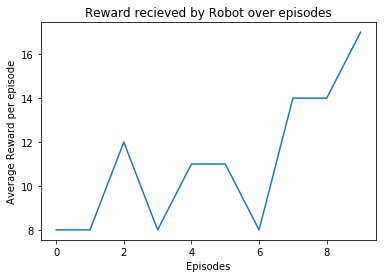

In [155]:
plt.plot(avg_ep_reward)
plt.xlabel('Episodes')
plt.ylabel('Average Reward per episode')
plt.title('Reward recieved by Robot over episodes')
print("Each Episode consists of 20 transactions")